# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

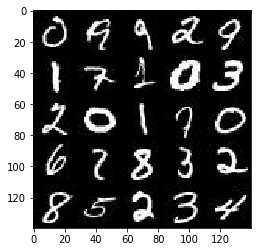

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

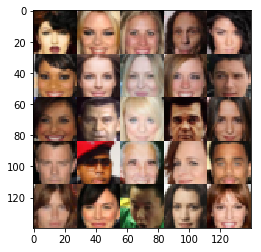

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [234]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64

        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x128
        
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [246]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x3x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # 28x28x out_channel_dim now

        # Scale to -0.5 tp 0.5
        out = 0.5 * tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

AssertionError: Generator output (is_train=True) has wrong shape.  Found [None, 24, 24, 5]

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [236]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [237]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [238]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [239]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    print_every = 10
    show_every = 100
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, out_channel_dim, data_image_mode)
                    
            

        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5732... Generator Loss: 0.4454
Epoch 1/2... Discriminator Loss: 1.7852... Generator Loss: 0.4873
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.5509


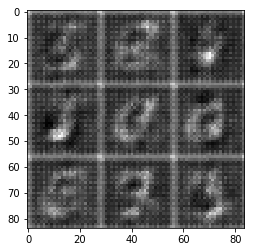

Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.6874
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.4147
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.1290


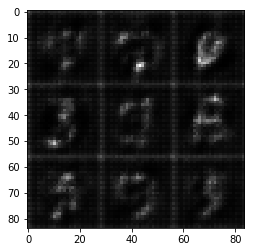

Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 1.2223
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.0132
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.0188... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.8533


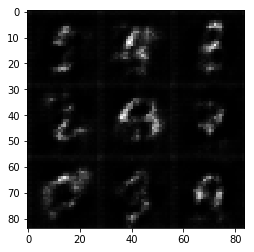

Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 1.3626
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 1.6374
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.5875
Epoch 1/2... Discriminator Loss: 0.8650... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 1.6072
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 1.4040
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 0.8011


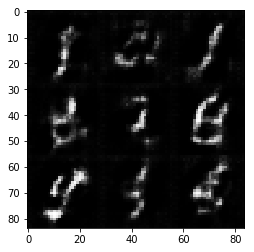

Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.0575
Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 0.9836
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 1.0084
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.1457
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 1.1437
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 1.1473


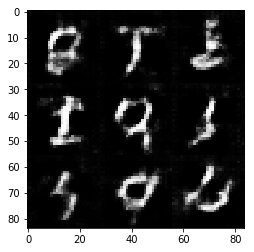

Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.6550
Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 1.2460
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 0.5152
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.6108
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 1.3230


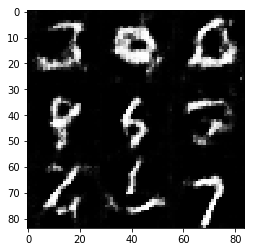

Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 1.5585
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 1.3533
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 0.7199


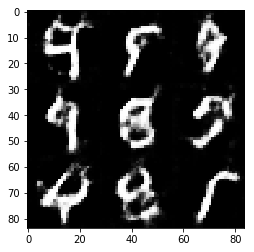

Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.4780
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.6383
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.0000
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.0750


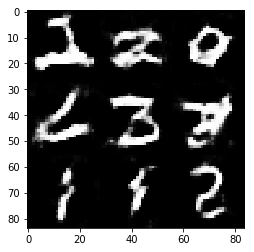

Epoch 1/2... Discriminator Loss: 0.9336... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.0229
Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.2357... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.9832
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.6083


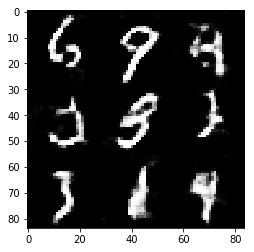

Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.6255
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 1.4585
Epoch 2/2... Discriminator Loss: 0.9954... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.0856
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 1.2200
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 0.8326


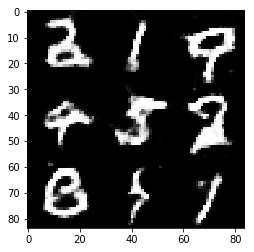

Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 0.9734
Epoch 2/2... Discriminator Loss: 1.0172... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 1.7153
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 0.9999
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 1.2249
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 1.5377


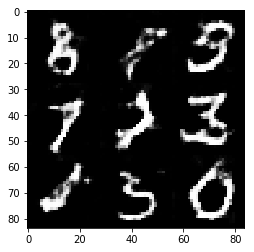

Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.0968
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 0.8518... Generator Loss: 1.2030
Epoch 2/2... Discriminator Loss: 1.5265... Generator Loss: 0.3115
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.7415


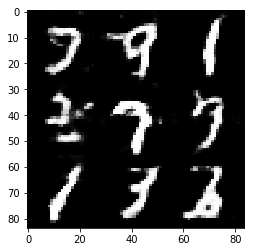

Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 1.2538
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 0.8720
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.0677
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 1.1904


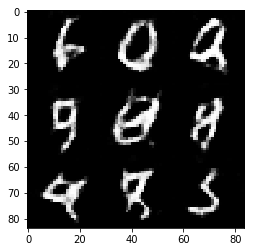

Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 1.6243
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 0.7074
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 0.9281
Epoch 2/2... Discriminator Loss: 0.8677... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 0.9606... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 0.9102


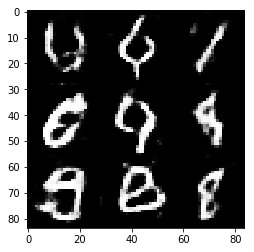

Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 0.5765
Epoch 2/2... Discriminator Loss: 3.6522... Generator Loss: 4.5313
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.1654
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.3698
Epoch 2/2... Discriminator Loss: 0.7610... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.1532
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 0.7775


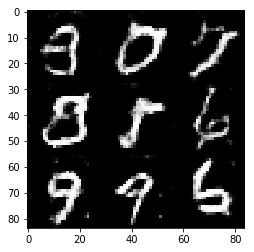

Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.9751
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 0.9237


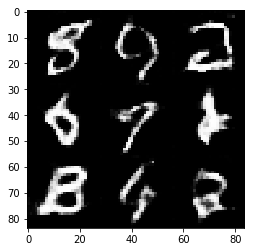

Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.3866
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 0.9691
Epoch 2/2... Discriminator Loss: 0.7576... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 1.4112
Epoch 2/2... Discriminator Loss: 0.8115... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.9869
Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 0.7138... Generator Loss: 1.3886
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.9631
Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 0.8777


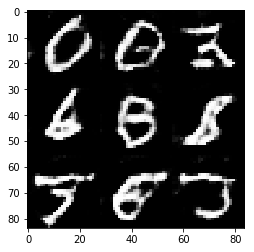

Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 0.8149... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.2564
Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.0377
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.1918
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.2274
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.0069


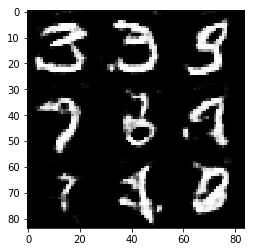

Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.4587
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 0.6103
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 1.3976
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.1215


In [241]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.